In [60]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [61]:
# read in all the words
words = open('lotr_names.txt', 'r').read().splitlines()
words[:8]

['adalbert',
 'adaldrida',
 'adalgar',
 'adalgrim',
 'adamanta',
 'adanel',
 'adelard',
 'adrahil']

In [62]:
len(words)

839

In [63]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: 'á', 27: 'â', 28: 'ä', 29: 'é', 30: 'ê', 31: 'ë', 32: 'í', 33: 'î', 34: 'ó', 35: 'ö', 36: 'ú', 37: 'û', 0: '.'}


In [64]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [65]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([6179, 3]), torch.int64, torch.Size([6179]), torch.int64)

In [66]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([4952, 3]) torch.Size([4952])
torch.Size([623, 3]) torch.Size([623])
torch.Size([604, 3]) torch.Size([604])


In [67]:
C = torch.randn((len(itos), 2))

In [68]:
emb = C[X]
emb.shape

torch.Size([6179, 3, 2])

In [69]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [70]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [71]:
h

tensor([[ 0.9306,  0.0479, -0.9624,  ...,  0.3417,  0.9957, -0.9755],
        [-0.8967,  0.9961, -0.9989,  ..., -0.3059,  0.5874, -0.9955],
        [ 0.9658,  0.9665,  0.9407,  ..., -0.7954, -0.8504, -0.3501],
        ...,
        [ 0.9686,  0.4983, -0.9900,  ..., -0.6950,  0.9990, -0.9943],
        [-0.8967,  1.0000, -0.9893,  ..., -0.9320, -0.9907, -1.0000],
        [ 1.0000,  0.9647, -0.9999,  ..., -0.9570,  0.9995, -0.9997]])

In [72]:
h.shape

torch.Size([6179, 100])

In [73]:
W2 = torch.randn((100, len(itos)))
b2 = torch.randn(len(itos))

In [74]:
logits = h @ W2 + b2

In [75]:
logits.shape

torch.Size([6179, 38])

In [76]:
counts = logits.exp()

In [77]:
prob = counts / counts.sum(1, keepdims=True)

In [78]:
prob.shape

torch.Size([6179, 38])

In [79]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(19.7990)

In [80]:
# ------------ now made respectable :) ---------------

In [81]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([4952, 3]), torch.Size([4952]))

In [96]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((len(itos), 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, len(itos)), generator=g)
b2 = torch.randn(len(itos), generator=g)
parameters = [C, W1, b1, W2, b2]

In [97]:
sum(p.nelement() for p in parameters) # number of parameters in total

14218

In [98]:
for p in parameters:
  p.requires_grad = True

In [99]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [100]:
lri = []
lossi = []
stepi = []

In [101]:
len(itos)

38

In [102]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (len(itos),))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

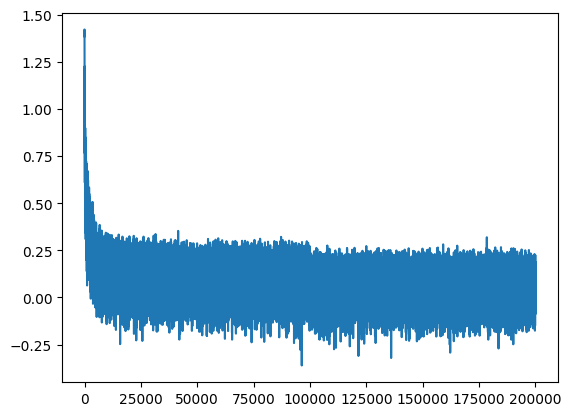

In [103]:
plt.plot(stepi, lossi)

In [104]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.1615, grad_fn=<NllLossBackward0>)

In [105]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(4.0321, grad_fn=<NllLossBackward0>)

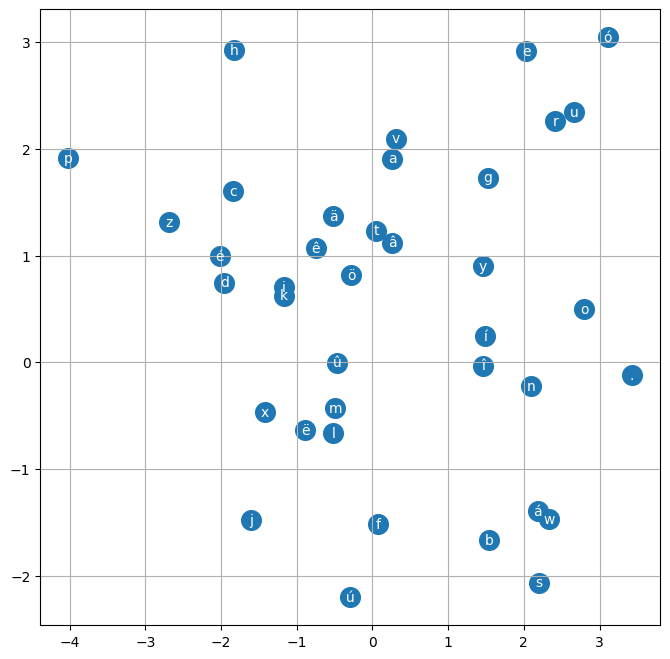

In [106]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [93]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [43]:


# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

khojzhgvzoáwxuht.
korht.
kkfkksnvhddsáthwzzhjkdiyjzsnvyjkczntsrht.
kkfkksnnywzmhjkuiyjzsnvyjnhgvzoáwxvhjszhczztexzltovhoáxidigdzyáwkhhjkzikkovhoáxidigdzyáwkhhjkdokhdnetexgmuiofwxouht.
kkfkcowxiyuzyfwxowtwcwkhhjkshywkkhgkbznsshthxjkhgkbdnsáccwnhgvzoáwxvcowxuhtlsunyjkczntsrht.
khfckzfkjszhczzhjkigkzojwxhyázságuhyjzshguryxcxzhthwzzhjkdoexiduetjshgvzoáwxvhjszhczztexdktjshgvzoáwxuht.
kkhgkbdnsáccwnhgvzoáwxuhtlkdiyjzsnvhddsáwxuht.
kkfkksnnywzmhjkdokhdneteyjkczndjehgkbdnsáccwnhgvzoáwxuhtlsunyxuetjshgvzoáwxuhtlkdiyjzsnvyjkczntsrht.
khcczhgvzsshthxjkficbetssmhokzsnvhoáxidigdzyáwkhhjkdgyzzoadiddythwzzhddsexaejkhgkbdnsáoahyjzsngueyjkczntsrht.
khfckzfkhojzigdzyáwkhhjkshywkkhgkbdnsáccwnhgvzoáwxvcowxiyuzyfwxowtwxiyuzyfwxowtwcwwzhczzthwzzhjkdokhdnetexgmuiofwxuhtlshcgfccamhjáigkzojwxvcozhthxzdzshgvzoáwxvcowxuhtlshcgfzzoaddsáwxvcowxuhtlodvhjszhczzthwzzhjkdokhinekkhgkbdnsákhojxiduetjshgvzoáwxuhtlsfvcozhthodiddadiddadiddythwzzhjkdiyjzsnvyjkczntsrht.
khfckzfkcozhthwzzhjkdokhdneteyjkczntsnthyjzsnvhddsxvxdd